# ADALINE monolayer network for regression and audio signal separation

## Imports
Code section that contains all the necessary imports for the full execution of the prediction algorithm.

In [1]:
# Imports
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from scipy.io.wavfile import write

## ADALINE multi-output class definition
This section defines the ADALINE neural network class, which can handle multiple outputs and is designed to recover multiple signals from input data. It includes methods for predicting and training the network.

In [2]:
class AdalineMultiOutput:
    def __init__(self, input_size, output_size=3, learning_rate=0.001, epochs=100):
        """
        Initializes the ADALINE network with multiple outputs.

        Parameters:
        - input_size: Number of input features (excluding the bias).
        - output_size: Number of outputs (signals to recover).
        - learning_rate: Learning rate for weight updates.
        - epochs: Number of iterations over the training set.
        """
        # Initialize weights: one row per output, including the bias
        self.weights = np.zeros((output_size, input_size + 1))
        self.learning_rate = learning_rate
        self.epochs = epochs

        # Error vector
        self.errors = []

    def predict(self, x):
        """
        Makes a prediction for a single input sample.

        Parameters:
        - x: Input vector.

        Returns:
        - Predicted output vector.
        """
        # Insert bias term
        x = np.insert(x, 0, 1)  

        # Dot product for each output
        return np.dot(self.weights, x)  

    def train(self, X, D):
        """
        Trains the ADALINE network using the provided dataset.

        Parameters:
        - X: Input matrix (n_samples, input_size).
        - D: Desired output matrix (n_samples, output_size).
        """
        for epoch in range(self.epochs):
            # Calculate mean squared error (MSE)
            mse_ = 0

            for i in range(len(X)):
                # Insert bias term
                x_i = np.insert(X[i], 0, 1)  
                
                # Current prediction
                y = np.dot(self.weights, x_i)  
                
                # Prediction error
                error = D[i] - y  

                # Accumulate MSE
                mse_ += sum(error ** 2)

                # Update weights for each output
                self.weights += 2 * self.learning_rate * np.outer(error, x_i)

            self.errors.append(np.mean(mse_))

            # Optionally print the average error every certain number of epochs
            if (epoch + 1) % 20 == 0:
                y_pred = self.predict_batch(X)
                mse = np.mean((D - y_pred) ** 2)

                self.errors.append(mse)

                print(f"Epoch {epoch + 1}/{self.epochs} - MSE: {mse:.5f}")

    def predict_batch(self, X):
        """
        Makes predictions for a batch of input samples.

        Parameters:
        - X: Input matrix (n_samples, input_size).

        Returns:
        - Predicted output matrix (n_samples, output_size).
        """
        # Insert bias term into all samples
        X_bias = np.insert(X, 0, 1, axis=1)  

        # Dot product for all outputs
        return np.dot(X_bias, self.weights.T)  	

## Constants
Defines constants for audio duration, frequency, and placeholders for file names.

In [3]:
# Audio constants 
AUDIO_DURATION = 10
AUDIO_FREQUENCY = 44100

# File name constants
FIRST_AUDIO_NAME = "FirstAudio.wav"
SECOND_AUDIO_NAME = "SecondAudio.wav"
BACKGROUND_AUDIO_NAME = "ThirdAudio.wav"

## Capture sound function
Captures audio from the default input device for a specified duration and frequency, handles potential errors, and returns the audio as a flattened NumPy array.

In [33]:
# Function to capture sound from the microphone
def capture_sound(duration=AUDIO_DURATION, frequency=AUDIO_FREQUENCY):
    print("Recording...")

    # Capture audio from the microphone
    audio = sd.rec(int(duration * frequency), samplerate=frequency, channels=1, dtype="float64")
    sd.wait()  # Wait until the recording is complete

    print("Recording finished")

    # Flatten the audio array (converts 2D array to 1D)
    audio = audio.flatten()

    return audio

# Capture the audios 
first_audio = capture_sound()
second_audio = capture_sound()
third_audio = capture_sound()

Recording...
Recording finished
Recording...
Recording finished
Recording...
Recording finished


## Save audio function
Saves the audio data to a `.wav` file if the file does not already exist. Handles exceptions related to file existence and invalid audio data.

In [37]:
# Save the audio data as WAV files
def save_audio(file_name, audio, frequency=AUDIO_FREQUENCY):
    try:
        # Check if the file already exists
        if os.path.exists(file_name):
            raise FileExistsError(f"File '{file_name}' already exists and will not be overwritten.")
        
        # Validate the audio data
        if audio.size == 0:
            raise ValueError("Audio data is empty or invalid. Cannot save file.")

        # Save the audio file
        write(file_name, frequency, audio)
        print(f"Audio saved as {file_name}")
    except FileExistsError as fe:
        print(f"Error: {fe}")
    except ValueError as ve:
        print(f"Error: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred while saving the audio: {e}")

# Audios saved as WAV files
save_audio(FIRST_AUDIO_NAME, first_audio)
save_audio(SECOND_AUDIO_NAME, second_audio)
save_audio(BACKGROUND_AUDIO_NAME, third_audio)

Audio saved as FirstAudio.wav
Audio saved as SecondAudio.wav
Audio saved as ThirdAudio.wav


## Trimming audio files
This function trims audio signals to a specified duration (default is `AUDIO_DURATION`). It supports multi-channel audio and converts it to mono if needed.

In [38]:
# Function to trim audio to a specified duration
def trim_audio(audio, duration=AUDIO_DURATION, frequency=AUDIO_FREQUENCY):
    # Calculate number of samples to retain based on duration
    num_samples = int(duration * frequency)
    
    # If audio has more than one channel, convert it to mono by averaging channels
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    
    # Trim the audio to the specified number of samples
    trimmed_audio = audio[:num_samples]

    return trimmed_audio

# Audios trimmed to the specified duration
first_audio = trim_audio(wavfile.read(FIRST_AUDIO_NAME)[1])
second_audio = trim_audio(wavfile.read(SECOND_AUDIO_NAME)[1])
noisy_audio = trim_audio(wavfile.read(BACKGROUND_AUDIO_NAME)[1])

## Play audio function
This function, `play_audio`, takes in an audio signal and plays it using a specified sampling frequency. It handles cases where the audio is in `float64` format by normalizing the data.

In [39]:
# Function to play audio
def play_audio(audio, frequency=AUDIO_FREQUENCY):
    # Normalize audio if it's in float64 format
    if audio.dtype == np.float64:
        # Normalize to range [-1, 1]
        audio = audio / np.max(np.abs(audio))  

    # Play the audio
    sd.play(audio, samplerate=frequency)
    sd.wait()

# Audios to play
play_audio(first_audio)
play_audio(second_audio)
play_audio(noisy_audio)

## Plot audio signal function
This function, `plot_audio_signal`, is responsible for plotting an audio signal over time. It normalizes the audio data if necessary and creates a time axis based on the sampling frequency.

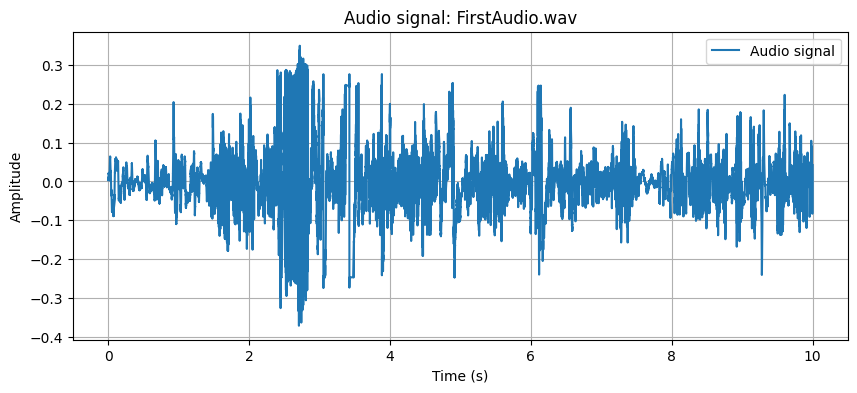

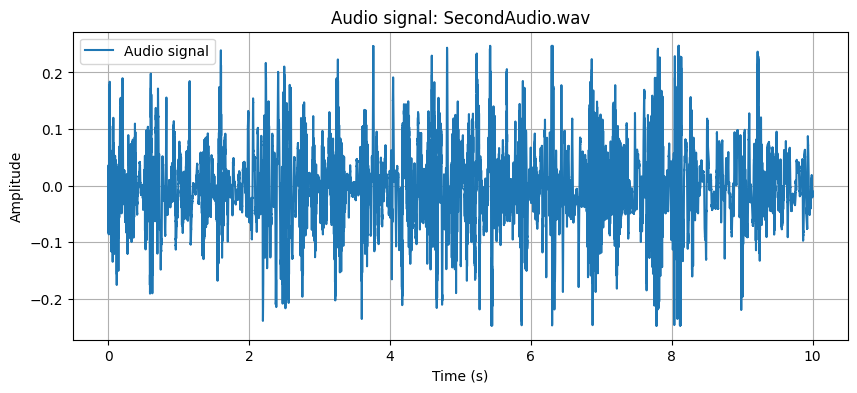

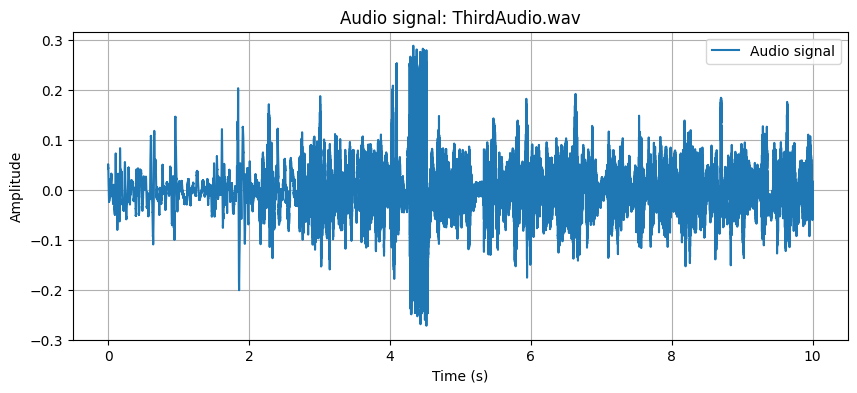

In [42]:
# Plot the audio signal
def plot_audio_signal(audio, file_name, frequency=AUDIO_FREQUENCY):
    # Normalize audio if in int16 or int32 format
    if audio.dtype == np.int16:
        audio = audio / 32767  # Normalize to range [-1, 1]
    elif audio.dtype == np.int32:
        audio = audio / 2147483647  # Normalize to range [-1, 1]
    
    # Create a time axis for plotting
    time = np.linspace(0, len(audio) / frequency, num=len(audio))
    
    # Plot the audio signal
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio, label="Audio signal")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f"Audio Signal: {file_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Audio signals plotted
plot_audio_signal(first_audio, FIRST_AUDIO_NAME)
plot_audio_signal(second_audio, SECOND_AUDIO_NAME)
plot_audio_signal(noisy_audio, BACKGROUND_AUDIO_NAME)

## Normalize audio function
This function, `normalize_audio`, normalizes the audio signal to ensure that its maximum amplitude is 1 and that its minimum amplitude is -1.

In [44]:
# Function to normalize audio in [-1, 1] range
def normalize_audio(audio):
    # Compute the maximum amplitude of the audio signal
    max_amplitude = np.max(np.abs(audio))
    
    # Normalize the audio data if the maximum amplitude is greater than 0
    if max_amplitude > 0:
        return audio / max_amplitude
    
    return audio

## Process and visualize audio function
Combines multiple audio signals, plays the composed audio, and plots the audio signal. 

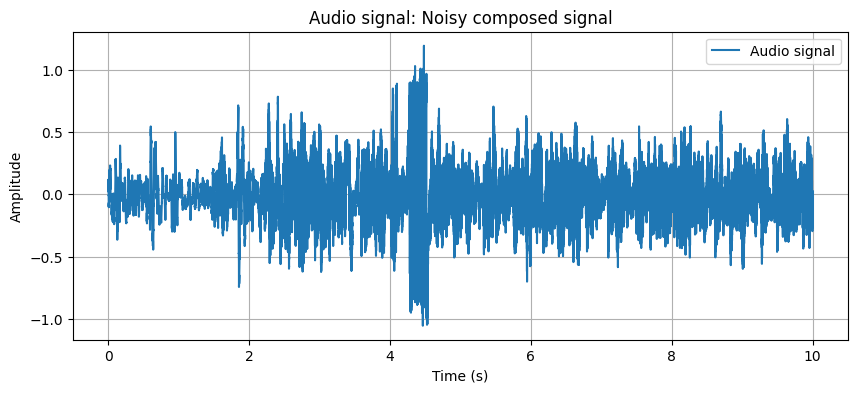

In [45]:
# Combine the audio signals
noisy_composed_signal = first_audio + second_audio + noisy_audio

# Normalize the composed audio signal
noisy_composed_signal = normalize_audio(noisy_composed_signal)

# Play the composed audio signal
play_audio(noisy_composed_signal)

# Plot the composed audio signal
plot_audio_signal(noisy_composed_signal, "Noisy composed signal")

## ADALINE network training
We set up the ADALINE network and train it using the noisy composite signal to recover the original sinusoidal signals.

In [62]:
# Ensure noisy_composed_signal is a NumPy array
noisy_composed_signal = np.array(noisy_composed_signal)

# Check and adjust the length of all signals to the minimum length
min_length = min(len(noisy_composed_signal), len(first_audio), len(second_audio), len(noisy_audio))
noisy_composed_signal = noisy_composed_signal[:min_length]
first_audio = first_audio[:min_length]
second_audio = second_audio[:min_length]
noisy_audio = noisy_audio[:min_length]

# Set up ADALINE parameters
delay = 40
n_samples = min_length - delay

# Create the input matrix X with windows from the composed signal
X = np.array([noisy_composed_signal[i: i + delay] for i in range(n_samples)])

# Create the desired output matrix D
d1 = first_audio[delay:]
d2 = second_audio[delay:]
d3 = noisy_audio[delay:]
D = np.stack((d1, d2, d3), axis=1)  # Desired output matrix (n_samples, 3)

# Print the dimensions of X and D for verification
print(f"Dimensions of X: {X.shape}")
print(f"Dimensions of D: {D.shape}")

# Create and train the multi-output ADALINE network
adaline = AdalineMultiOutput(input_size=40)
adaline.train(X, D)

Dimensiones de X: (440960, 40)
Dimensiones de D: (440960, 3)
Epoch 20/250 - MSE: 0.00698
Epoch 40/250 - MSE: 0.00698
Epoch 60/250 - MSE: 0.00697
Epoch 80/250 - MSE: 0.00697
Epoch 100/250 - MSE: 0.00697
Epoch 120/250 - MSE: 0.00696
Epoch 140/250 - MSE: 0.00696
Epoch 160/250 - MSE: 0.00696
Epoch 180/250 - MSE: 0.00696
Epoch 200/250 - MSE: 0.00696
Epoch 220/250 - MSE: 0.00696
Epoch 240/250 - MSE: 0.00696


## Signal recovery
After training the ADALINE network, we use it to recover the three original signals from the noisy composite input.

In [63]:
# Recover the signals using the trained ADALINE network
# Recovered output matrix (n_samples - delay, 3)
recovered_signals = adaline.predict_batch(X)  
recovered_signal1 = recovered_signals[:, 0]
recovered_signal2 = recovered_signals[:, 1]
recovered_signal3 = recovered_signals[:, 2]

# Error visualization
We plot the global error (mean squared error) of the ADALINE network over epochs to see how the network improves its predictions with each epoch.

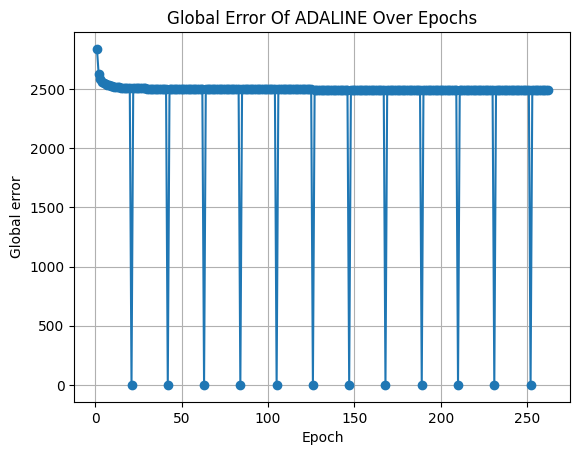

In [64]:
# Plot the MSE over epochs
plt.figure()
plt.plot(range(1, len(adaline.errors) + 1), adaline.errors, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Global error')
plt.title('Global Error Of ADALINE Over Epochs')
plt.grid(True)

# Signal comparison
We compare the noisy composite signal with the original signals and the recovered signals from the ADALINE network.

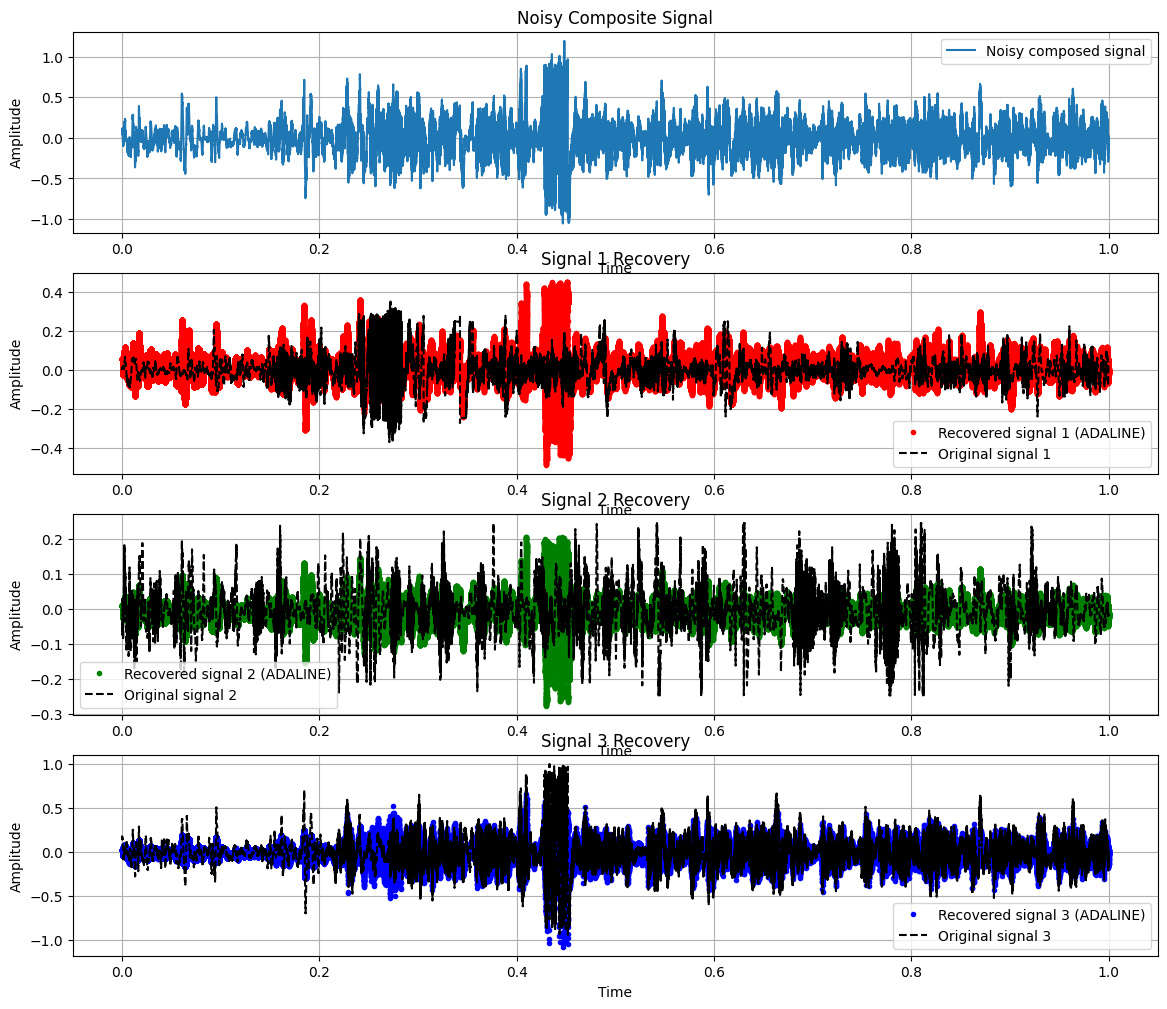

In [65]:
# Create a time (s) axis for plotting
t = np.linspace(0, 1, len(noisy_composed_signal))

# Plot the original signals, noisy composite signal, and recovered signals
plt.figure(figsize=(14, 12))

# Noisy composite signal
plt.subplot(4, 1, 1)
plt.plot(t, noisy_composed_signal, label="Noisy composed signal")
plt.title("Noisy Composite Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Signal 1: Original vs Recovered
plt.subplot(4, 1, 2)
plt.plot(t[delay:], recovered_signal1, '.', label="Recovered signal 1 (ADALINE)", color="r")
plt.plot(t, first_audio, '--', label="Original signal 1", color="k")
plt.title("Signal 1 Recovery")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Signal 2: Original vs Recovered
plt.subplot(4, 1, 3)
plt.plot(t[delay:], recovered_signal2, '.', label="Recovered signal 2 (ADALINE)", color="g")
plt.plot(t, second_audio, '--', label="Original signal 2", color="k")
plt.title("Signal 2 Recovery")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Signal 3: Original vs Recovered
plt.subplot(4, 1, 4)
plt.plot(t[delay:], recovered_signal3, '.', label="Recovered signal 3 (ADALINE)", color="b")
plt.plot(t, noisy_audio, '--', label="Original signal 3", color="k")
plt.title("Signal 3 Recovery")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)